# Projet de Machine Learning

**Réalisé par:** 
- Yanis GUERDOU
- Ilhan Acherchour

**Dataset étudié:**
>DVF (Demande de Valeur Foncière) - Sujet 1

**Objectif:** 
> Fabriquer un modèle permettant de prédire au mieux le prix d'un appartement à partir de ses autres caractéristiques.



Le dataset qui nous est soumis à l'étude est une base de données regroupant les transactions immobilières en France produit par la Direction générale des finances publiques.

Ce jeu de données nous fourni beaucoup d'informations sur le bien qui a été vendu (tel que sa géolocalisation, sa surface réelle bati, la surface de son terrain, le type de bien, ..etc).

Notre but est donc de créer un modele capable de prédire au mieux la valeur fonciere de ses biens.

**Explorons donc le dataset**

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
dvf = pd.read_csv("DVF_train.csv")

In [8]:
dvf.dtypes

Unnamed: 0                     int64
date_mutation                 object
valeur_fonciere              float64
code_postal                  float64
code_departement               int64
type_local                    object
surface_reelle_bati          float64
nombre_pieces_principales    float64
surface_terrain              float64
longitude                    float64
latitude                     float64
dtype: object

Afin de mieux étudier ce dataset et le préparer pour notre modele de regression, nous devons transformer nos colonnes de type non numérique en type numérique.

In [9]:
# Convertion de la colonne date_mutation en timestamp (secondes depuis 1970)
dvf['date_mutation'] = pd.to_datetime(dvf['date_mutation'], errors='coerce')
dvf['date_mutation'] = dvf['date_mutation'].astype(int) / 10**9

In [10]:
print(dvf['type_local'].unique())

['Appartement' 'Maison']


La colonne type_local ayant deux valeurs (str) differentes, nous allons donc transformer cette colone grace au LabelEncoder, qui transformera les itération de 'Appartement' en 0 et celles de 'Maison' en 1

In [11]:
# Code provenant de ChatGPT

from sklearn.preprocessing import LabelEncoder

# Initialiser le LabelEncoder
label_encoder = LabelEncoder()

# Appliquer le LabelEncoder sur la colonne 'type_local'
dvf['type_local'] = label_encoder.fit_transform(dvf['type_local'])

# Vérifier les résultats
print(dvf['type_local'].unique())

[0 1]


Désormais nos colonnes sont toutes de type numérique il est temps d'étudier ce dataset


In [12]:
dvf

,Unnamed: 0,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,3612399,1.691021e+09,165410.0,94160.0,94,0,17.0,1.0,NaN,2.416612,48.840466
1,2979296,1.684800e+09,170900.0,78300.0,78,0,80.0,4.0,NaN,2.040845,48.926907
2,545016,1.685491e+09,16000.0,16000.0,16,0,20.0,1.0,NaN,0.170911,45.651279
3,2497199,1.687997e+09,240000.0,65400.0,65,0,75.0,3.0,621.0,-0.068876,42.988343
4,3207821,1.676506e+09,522000.0,84400.0,84,1,165.0,5.0,1000.0,5.384564,43.911069
...,...,...,...,...,...,...,...,...,...,...,...
703768,1045273,1.672704e+09,60000.0,30000.0,30,0,22.0,1.0,NaN,4.396774,43.854210
703769,1837384,1.680826e+09,250000.0,46230.0,46,1,140.0,4.0,500.0,1.546814,44.344308
703770,579086,1.684886e+09,558000.0,17139.0,17,1,135.0,6.0,657.0,-1.056342,46.192404
703771,1722782,1.681171e+09,360000.0,44230.0,44,1,74.0,4.0,363.0,-1.489895,47.198482


In [13]:
dvf.describe()

,Unnamed: 0,date_mutation,valeur_fonciere,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
count,7.037730e+05,7.037730e+05,7.037730e+05,703731.000000,703773.000000,703773.000000,703672.000000,703672.000000,515266.000000,698135.000000,698135.000000
mean,1.886729e+06,1.688304e+09,3.473074e+05,49629.926951,49.302521,0.652769,84.671122,3.547069,981.433865,2.286872,46.706530
std,1.064297e+06,8.994350e+06,6.822107e+05,26787.811049,26.786998,0.476090,47.776371,1.653663,4439.650550,2.719983,2.324414
min,1.000000e+00,1.672618e+09,1.000000e+04,1000.000000,1.000000,0.000000,1.000000,0.000000,1.000000,-5.100946,41.363301
25%,9.780400e+05,1.680307e+09,1.230000e+05,28800.000000,28.000000,0.000000,52.000000,2.000000,250.000000,0.282417,44.613697
50%,1.923575e+06,1.688083e+09,2.020000e+05,49390.000000,49.000000,1.000000,80.000000,4.000000,500.000000,2.365781,47.040129
75%,2.826241e+06,1.695859e+09,3.300000e+05,74520.000000,74.000000,1.000000,106.000000,5.000000,866.000000,4.388724,48.772017
max,3.799337e+06,1.703981e+09,9.900000e+06,95880.000000,95.000000,1.000000,1250.000000,95.000000,713830.000000,9.556736,51.081916


In [14]:
dvf['valeur_fonciere'].describe().apply(lambda x: format(x,'f'))

count     703773.000000
mean      347307.439395
std       682210.713915
min        10000.000000
25%       123000.000000
50%       202000.000000
75%       330000.000000
max      9900000.000000
Name: valeur_fonciere, dtype: object

In [15]:
corr_matrix = dvf.corr()

In [16]:
corr_matrix["valeur_fonciere"].sort_values(ascending=False)

valeur_fonciere              1.000000
surface_terrain              0.122772
surface_reelle_bati          0.090700
Unnamed: 0                   0.088583
code_departement             0.077474
code_postal                  0.077311
longitude                    0.062113
nombre_pieces_principales    0.042876
date_mutation                0.038842
latitude                    -0.006929
type_local                  -0.102644
Name: valeur_fonciere, dtype: float64

On remarque qu'il y a une tres faible corrélation entre la colonne valeur_fonciere et toutes les autres colonnes.

In [17]:
#moyenne des prix en fonction du type de local

dvf.groupby('type_local')['valeur_fonciere'].mean()

type_local
0    443318.424661
1    296235.725377
Name: valeur_fonciere, dtype: float64

In [18]:
#moyenne des prix en fonction des département

dvf.groupby('code_departement')['valeur_fonciere'].mean().sort_values(ascending=False).apply(lambda x: format(x,'f'))

code_departement
92    996875.155441
75    945219.317468
94    842270.653871
6     593832.988016
69    570812.737543
          ...      
70    143315.853076
15    135752.345187
52    122033.849704
58    117516.136704
23    109819.833338
Name: valeur_fonciere, Length: 92, dtype: object

In [19]:
# Proportion des valeurs = NaN ou inexistantes

dvf.isna().mean()

Unnamed: 0                   0.000000
date_mutation                0.000000
valeur_fonciere              0.000000
code_postal                  0.000060
code_departement             0.000000
type_local                   0.000000
surface_reelle_bati          0.000144
nombre_pieces_principales    0.000144
surface_terrain              0.267852
longitude                    0.008011
latitude                     0.008011
dtype: float64

ci dessus la proportion des valeurs NaN par colonne, il est insdispensable de se débarasser des valeurs NaN afin de mener à bien notre régréssion, ainsi nous allons juste supprimer les lignes contenant NaN

In [20]:
dvf = dvf.dropna()

## Création du modele:

Nous allons tout d'abord séparer notre jeu de données, de sorte à avoir les labels que l'on souhaite prédire ("valeur_fonciere") d'une part et le reste des colonnes constitura nos observations.

Par la suite, nous allons à nouveau séparer notre jeu de données en jeu de test et d'entrainement pour débuter l'entrainement du modele

In [21]:
X = dvf.drop("valeur_fonciere", axis=1)
y = dvf['valeur_fonciere']

In [22]:
X


,Unnamed: 0,date_mutation,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
3,2497199,1.687997e+09,65400.0,65,0,75.0,3.0,621.0,-0.068876,42.988343
4,3207821,1.676506e+09,84400.0,84,1,165.0,5.0,1000.0,5.384564,43.911069
5,2533956,1.695168e+09,66120.0,66,1,101.0,5.0,460.0,2.014244,42.502995
8,808793,1.687910e+09,24410.0,24,1,120.0,5.0,3728.0,0.169340,45.216226
9,894942,1.695082e+09,26600.0,26,1,144.0,7.0,643.0,4.881313,45.085293
...,...,...,...,...,...,...,...,...,...,...
703767,796205,1.680048e+09,24410.0,24,1,125.0,3.0,36171.0,0.208804,45.219826
703769,1837384,1.680826e+09,46230.0,46,1,140.0,4.0,500.0,1.546814,44.344308
703770,579086,1.684886e+09,17139.0,17,1,135.0,6.0,657.0,-1.056342,46.192404
703771,1722782,1.681171e+09,44230.0,44,1,74.0,4.0,363.0,-1.489895,47.198482


In [23]:
y

3         240000.0
4         522000.0
5         403260.0
8         181000.0
9         279000.0
            ...   
703767    228500.0
703769    250000.0
703770    558000.0
703771    360000.0
703772    258450.0
Name: valeur_fonciere, Length: 510410, dtype: float64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
X_train

,Unnamed: 0,date_mutation,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
476905,399856,1.684973e+09,13001.0,13,0,34.0,1.0,245.0,5.379438,43.295221
186341,1589366,1.688083e+09,40440.0,40,1,146.0,6.0,2800.0,-1.446096,43.560853
430573,668309,1.698710e+09,19210.0,19,1,65.0,1.0,500.0,1.450678,45.423051
100832,3231736,1.699488e+09,84360.0,84,0,29.0,1.0,810.0,5.300605,43.749224
312592,2801978,1.703722e+09,74320.0,74,1,190.0,5.0,790.0,6.139499,45.863657
...,...,...,...,...,...,...,...,...,...,...
294521,1184949,1.697069e+09,32440.0,32,1,90.0,6.0,4946.0,0.122750,43.963740
385617,2430736,1.693440e+09,63140.0,63,1,190.0,9.0,1281.0,3.036352,45.929031
514624,26901,1.690848e+09,1320.0,1,1,194.0,5.0,500.0,5.202182,46.035190
480298,2526903,1.688602e+09,66000.0,66,0,45.0,3.0,175.0,2.891945,42.710404


In [26]:
X_test

,Unnamed: 0,date_mutation,code_postal,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
236389,855445,1.690502e+09,25870.0,25,1,140.0,6.0,718.0,5.945122,47.337842
499163,3074459,1.702944e+09,80200.0,80,0,42.0,1.0,118.0,2.935635,49.927500
51309,2161746,1.700179e+09,56160.0,56,1,65.0,2.0,385.0,-3.203864,48.065806
631948,3072696,1.699920e+09,80650.0,80,1,83.0,5.0,270.0,2.193346,50.005840
416393,3118231,1.692922e+09,82210.0,82,1,112.0,4.0,1000.0,1.029374,44.004478
...,...,...,...,...,...,...,...,...,...,...
300778,2260339,1.683850e+09,59590.0,59,1,91.0,4.0,505.0,3.488787,50.379396
158745,192182,1.683850e+09,6510.0,6,1,45.0,3.0,38.0,7.124185,43.825614
477842,1826680,1.701216e+09,45400.0,45,1,62.0,4.0,432.0,1.908678,47.936347
526499,1955421,1.682640e+09,50580.0,50,1,48.0,3.0,1457.0,-1.679432,49.309417


In [27]:
y_train

476905     986820.7
186341    1050000.0
430573     278000.0
100832     576000.0
312592     630000.0
            ...    
294521     163000.0
385617     392480.0
514624     400000.0
480298     148000.0
8949       102500.0
Name: valeur_fonciere, Length: 382807, dtype: float64

In [28]:
y_test

236389    309500.0
499163     69000.0
51309      48000.0
631948    181250.0
416393    185000.0
            ...   
300778    260900.0
158745    135000.0
477842    146000.0
526499    160000.0
621340    610000.0
Name: valeur_fonciere, Length: 127603, dtype: float64

Apres plusieurs essais, nous avons décidé d'opter pour le modele de regression intitulé: "HistGradientBoostingRegressor" , il s'agit d'un modele de regression idéal pour les dataset avec beaucoup d'observations. De plus, de tous ceux qu'on a tester, c'est le plus efficace.

Tout d'abord, nous avons fais le choix de normaliser nos observations car celles ci ont chacune une échelle différente ainsi qu'un plage tres elevé dans le cas de nos labels

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

In [30]:
model = HistGradientBoostingRegressor(loss = "squared_error", max_depth=1000, learning_rate=.5, max_iter = 10000, max_leaf_nodes = 100)
model.fit(X_train_scaled, y_train_scaled)

HistGradientBoostingRegressor(learning_rate=0.5, max_depth=1000, max_iter=10000,
                              max_leaf_nodes=100)

In [31]:
train_predictions = scaler_y.inverse_transform(model.predict(X_train_scaled).reshape(-1, 1))
test_predictions = scaler_y.inverse_transform(model.predict(X_test_scaled).reshape(-1, 1))


mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)

print("MSE (Entraînement) : ", mse_train)
print("MSE (Test) :", mse_test)

MSE (Entraînement) :  35713182522.03583
MSE (Test) : 70511606729.95781


Visualisons les résultats de nos prédictions par rapport aux valeurs réelles

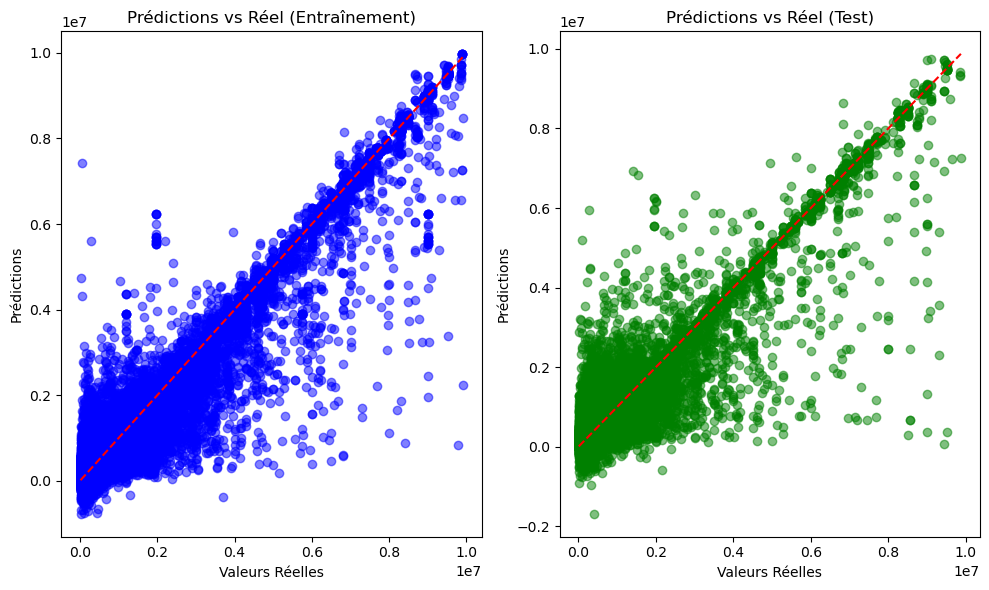

In [32]:
plt.figure(figsize=(10, 6))

# Pour l'entraînement
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions, color='blue', alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.title('Prédictions vs Réel (Entraînement)')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')

# Pour le test
plt.subplot(1, 2, 2)
plt.scatter(y_test, test_predictions, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Prédictions vs Réel (Test)')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')

plt.tight_layout()
plt.show()
